__Preamble__

- Most of this should be in your environment already though you will likely have to install chaospy w/ 'pip install chaospy' 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import chaospy as ch
from scipy import integrate
import pandas as pd
from mpl_toolkits import mplot3d
import time
import json
import pickle

##SALib
from SALib.sample import saltelli
from SALib.analyze import sobol
from SALib.test_functions import Ishigami

#Chaospy
import chaospy as ch


__The Levotka-Volterra predator-prey model__

- Here we instantiate the Levotka-Volterra model, which models the interdependent population dynamics of predators and prey via two coupled differential equations. The equations further depend on four parameters. 
- This model will serve as the initial test-bed with which we can compare the virtues of polynomial chaos expansions in calculating sensitivity metrics. 

In [2]:
# Parameters
alpha = 1 #Mortality rate due to predators
beta = 1 #Regeneration rate of prey
delta = 1 #Search rate of predators
gamma = 1 #Death rate of predators.

#Initial condition
x0 = 4 #Initial population of prey
y0 = 2 #Initial population of predators
X0 = [x0, y0]

Nt = 1000
tmax = 30
t = np.linspace(0.,tmax, Nt)




In [3]:

#Model

def levotka(X, t, alpha, beta, delta, gamma):
    x, y = X
    dotx = x * (alpha - beta * y)
    doty = y * (-delta + gamma * x)
    return np.array([dotx, doty])

solution = integrate.odeint(levotka, X0, t, args = (alpha,beta,delta,gamma))

Solving the equations with the given initial conditions and parameter values gives the cyclical population dynamics typical of the Levotka-Volterra model. 

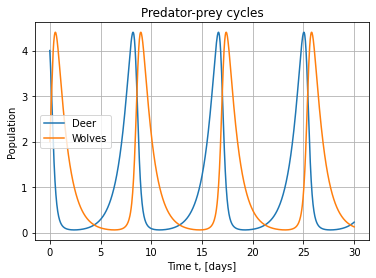

In [4]:
x = solution.T[0]
y = solution.T[1]

plt.figure()
plt.grid()
plt.title("Predator-prey cycles")
plt.plot(t, x, label = 'Deer')
plt.plot(t, y,  label = "Wolves")
plt.xlabel('Time t, [days]')
plt.ylabel('Population')
plt.legend()

plt.show()

__Sensitivity analysis__ 

- If we were a troupe of intrepid conservationists we might reasonably ask how the population dynamics produced by the model depends on the model parameters. 
- Conducting a global sensitivity analysis is a good start as it gives us information about uncertainty in the parameters effects the model output for a given quantity of interest.
- For the sake of ease we shall assume that we are interested in the predator and prey populations in tenth year. This will serve as our main quantity of interest in all following examples. 

__Sobol-Saltelli sensitivity analysis with SAlib__

SAlib requires us to define the parameters and their bounds in a dictionary from which the parameter samples will be drawn. The samples may then be constructed with the sample method using a low discrepancy sequence. 

In [5]:
problem = {
    'num_vars': 4,
    'names': ['alpha','beta','delta','gamma'],
    'bounds': [[0.44,0.68],
               [0.02,0.044],
               [0.71,1.15],
               [0.0226,0.0354]]
}

#We can now construct our samples

param = saltelli.sample(problem, 1024)

#With second-order indices to be calculated the above method produces N*(2D + 2) samples. W/ D = 4 we have 10N.

param.shape


(10240, 4)

A quick sanity check gives us a sample spread in Alpha and Beta which is typical of a low discrepancy sequence.

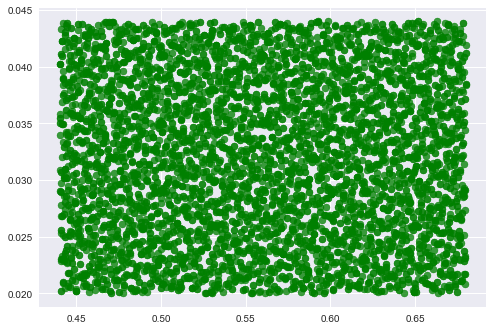

In [9]:
fig = plt.subplots()
plt.scatter(param.T[0],param.T[1], marker = 'o', alpha = 0.5, color='green')
plt.style.use('seaborn')

We can also get some idea of what the behaviour space looks like plotting data from all the function evaluations together. 

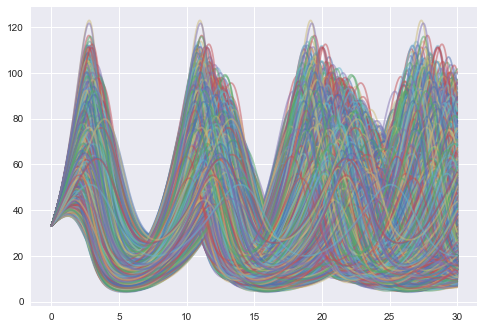

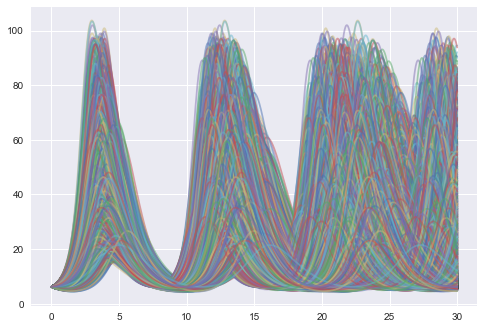

In [13]:
def manual_runner():
    
    #start_time = time.perf_counter() #start the timer
    samples = 1024 #we start with a small number of samples.
    params = saltelli.sample(problem, samples) #2560 samples.
    
    global Y
    Y = np.zeros((2,samples*(10),1000)) #prepare the array to take predator and prey populations in tenth year.
    x0 = 33
    y0 = 6.2
    X = [x0,y0]
    
    for i,ex in enumerate(params): #looping over samples set
        a,b,d,g = ex
        solution = integrate.odeint(levotka, X, t, args = (a,b,d,g))
        Y[0][i] = solution.T[0] #we extract the predator and prey populations in the tenth year and store it in our response array.
        Y[1][i] = solution.T[1]
    
    #print(time.perf_counter() - start_time, "seconds")
        
        
#manual_runner()

fig, ax1 = plt.subplots() ##These graphs are a bit messy and not totally illustrative but I was having a bit of trouble trying to plot min/max envelopes

for i in range(0,10240):
    ax1 = plt.plot(t,Y[0][i], alpha=0.5)
    
fig, ax1 = plt.subplots()  

for i in range(0,10240):
    ax1 = plt.plot(t,Y[1][i], alpha=0.5)



It is now straightforward to calculate the Sobol sensitivity indices. To do this we need to loop over our parameter set and run the model for each sample, extracting our quantity of interest for both the predator and prey populations as we go. We combine the entire procedure in a single function. 

In [25]:
def manual_runner():
    
    start_time = time.perf_counter() #start the timer
    samples = 256 #we start with a small number of samples.
    params = saltelli.sample(problem, samples) #2560 samples.
    
    global Y
    Y = np.zeros(((samples*(10)),2)) #prepare the array to take predator and prey populations in tenth year.
    x0 = 33
    y0 = 6.2
    X = [x0,y0]
    
    for i,ex in enumerate(params): #looping over samples set
        a,b,d,g = ex
        solution = integrate.odeint(levotka, X, t, args = (a,b,d,g))
        Y[i][0] = solution.T[0][910] #we extract the predator and prey populations in the tenth year and store it in our response array.
        Y[i][1] = solution.T[1][910]
    
    print(time.perf_counter() - start_time, "seconds")
        
        
manual_runner()

prey = Y.T[0] ## Only one of the populations.
pred = Y.T[1]

Si_prey = sobol.analyze(problem, prey, print_to_console=True) # The results are stored in a dictionary
Si_pred = sobol.analyze(problem, pred, print_to_console=True)




14.04412820000016 seconds
             ST   ST_conf
alpha  0.489381  0.120598
beta   0.123323  0.039280
delta  0.825301  0.181816
gamma  0.074984  0.032360
             S1   S1_conf
alpha  0.159101  0.115326
beta   0.011621  0.064114
delta  0.439701  0.106995
gamma  0.005804  0.060799
                      S2   S2_conf
(alpha, beta)  -0.043745  0.126205
(alpha, delta)  0.230107  0.196861
(alpha, gamma) -0.023408  0.136899
(beta, delta)   0.055719  0.097120
(beta, gamma)   0.002392  0.075356
(delta, gamma)  0.047960  0.141832
             ST   ST_conf
alpha  0.691743  0.217629
beta   0.278338  0.109364
delta  0.827655  0.261614
gamma  0.090739  0.053246
             S1   S1_conf
alpha  0.069377  0.160091
beta   0.052327  0.112850
delta  0.183272  0.194112
gamma  0.012251  0.049278
                      S2   S2_conf
(alpha, beta)   0.081281  0.223016
(alpha, delta)  0.400050  0.311428
(alpha, gamma)  0.004566  0.166227
(beta, delta)   0.137264  0.174548
(beta, gamma)  -0.041109  0.151727

{'S1': array([0.15910122, 0.01162064, 0.43970098, 0.00580399]),
 'S1_conf': array([0.1153262 , 0.06411352, 0.10699502, 0.0607994 ]),
 'ST': array([0.4893812 , 0.12332289, 0.82530127, 0.07498401]),
 'ST_conf': array([0.12059809, 0.03928023, 0.18181552, 0.03235981]),
 'S2': array([[        nan, -0.04374468,  0.23010717, -0.02340835],
        [        nan,         nan,  0.05571915,  0.00239203],
        [        nan,         nan,         nan,  0.04796022],
        [        nan,         nan,         nan,         nan]]),
 'S2_conf': array([[       nan, 0.1262048 , 0.19686134, 0.13689884],
        [       nan,        nan, 0.09712031, 0.07535562],
        [       nan,        nan,        nan, 0.14183243],
        [       nan,        nan,        nan,        nan]])}

We now compute the Sobol indices for successively greater number of samples to assess the optimal number of samples required for moderately high accuracy. 

In [58]:
##We fist instantiate the empty dictionary

alpha = { 
    '64' : 0,
    '256' : 0,
    '1024' : 0,
    '8192' : 0,
    '16384' :0
    
}

beta = {
    '64' : 0,
    '256' : 0,
    '1024' : 0,
    '8192' : 0, 
    '16384'  :0
    
}

delta = {
    '64' : 0,
    '256' : 0,
    '1024' : 0,
    '8192' : 0,
    '16384' :0
    
}

gamma = {
    '64' : 0,
    '256' : 0,
    '1024' : 0,
    '8192' : 0,
    '16384' :0
    
}

errors = {
    'alpha' : alpha ,
    'beta' : beta ,
    'delta' : delta ,
    'gamma' : gamma
}

errors_prey = errors
errors_pred = errors

errors

{'alpha': {'64': 0, '256': 0, '1024': 0, '8192': 0, '16384': 0},
 'beta': {'64': 0, '256': 0, '1024': 0, '8192': 0, '16384': 0},
 'delta': {'64': 0, '256': 0, '1024': 0, '8192': 0, '16384': 0},
 'gamma': {'64': 0, '256': 0, '1024': 0, '8192': 0, '16384': 0}}

In [60]:

samples = [64,256,1024]

def error_maker():
    
    for sample in samples:
        
        runner(sample)
        prey = Y.T[0]
        pred = Y.T[1]
        Si_prey = sobol.analyze(problem, prey, print_to_console=False)
        Si_pred = sobol.analyze(problem, pred, print_to_console=False)
        
        for i,N in enumerate(problem['names']):
            errors_prey[f'{N}'][f'{sample}'] = abs(prey_1684['S1'][i] - Si_prey['S1'][i])
            errors_pred[f'{N}'][f'{sample}'] = abs(pred_1684['S1'][i] - Si_pred['S1'][i])
            
        
        
def runner(samples):
    
    start_time = time.perf_counter()
    params = saltelli.sample(problem, samples)
    
    global Y
    Y = np.zeros(((samples*(10)),2))
    x0 = 33
    y0 = 6.2
    X = [x0,y0]
    
    for i,ex in enumerate(params):
        a,b,d,g = ex
        solution = integrate.odeint(levotka, X, t, args = (a,b,d,g))
        Y[i][0] = solution.T[0][910]
        Y[i][1] = solution.T[1][910]
    
    print(time.perf_counter() - start_time, "seconds")
        
        
error_maker()

3.7552673000009236 seconds
16.367840400000205 seconds
65.59371569999894 seconds


In [44]:
##Load Sobol indices from the large run to dictionaries

##Prey
file = open('data/Si_prey_16384.pkl','rb')
prey_1684 = pickle.load(file)

##Pred
file = open('data/Si_pred_16384.pkl','rb')
pred_1684 = pickle.load(file)

##Unit test
if (type(pred_1684) == dict) and type(prey_1684 == dict):
    print('Load successful')
    print(pred_1684.keys())
    print('order of parameters > alpha, beta, delta, gamma')
    
#for i,el in enumerate(errors.keys()):
    #errors_prey[f'{el}']['16384'] = prey_1684['S1'][i]
    #errors_pred[f'{el}']['16384'] = pred_1684['S1'][i]

Load successful
dict_keys(['S1', 'S1_conf', 'ST', 'ST_conf', 'S2', 'S2_conf'])
order of parameters > alpha, beta, delta, gamma


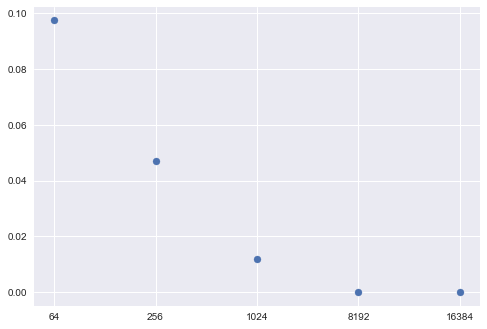

In [64]:
name = 'beta'
plt.scatter(errors_pred[f'{name}'].keys(), errors_pred[f'{name}'].values())

Because the highest accuracy is, naturally, obtained with the largest number of samples the data from this run will be used to compare the performance of the polynomial chaos expansions in determining the sensitivity indices. 

__Polynomial Chaos Expansion__

Refresher here > can plot out for single variables

We now define the parameter distributions from which the polynomial expansions in each variable will be constructed. 

In [39]:
##Parameters
alpha = ch.Uniform(0.44, 0.68) #We choose uniform distributions to reflect our lack of knowledge about the relative likelihood functions
beta = ch.Uniform(0.02, 0.044) #We take the same bounds as for the Sobol-Saltelli analysis
delta = ch.Uniform(0.71, 1.15)
gamma = ch.Uniform(0.0226, 0.0354)

joint = ch.J(alpha,beta,delta,gamma) #The input paramter distributions are assumed to be independent so we may easily construct the joint input probability distribution.

##Expansion
expansion = ch.generate_expansion(5, joint) #Here we generate the polynomial expansion which is truncated a maximum mixed order of 2.

Below is an example polynomial truncated to a maximum mixed order of 2 which contains 15 terms. This is the surrogate model which will be used to calculate the Sobol sensitivity indices. The terms are the polynomial basis vectors on which we will project the model output. First, however, we must solve for the expansion coefficients. 

In [24]:
expansion

polynomial([1.0, q3-0.028999999999999998, q2-0.9299999999999999, q1-0.032,
            q0-0.56, q3**2-0.057999999999999996*q3+0.0008273466666666665,
            q2*q3-0.9299999999999999*q3-0.028999999999999998*q2+0.026969999999999997,
            q2**2-1.8599999999999999*q2+0.8487666666666666,
            q1*q3-0.032*q3-0.028999999999999998*q1+0.000928,
            q1*q2-0.032*q2-0.9299999999999999*q1+0.029759999999999998,
            q1**2-0.064*q1+0.000976,
            q0*q3-0.56*q3-0.028999999999999998*q0+0.01624,
            q0*q2-0.56*q2-0.9299999999999999*q0+0.5208,
            q0*q1-0.56*q1-0.032*q0+0.017920000000000002,
            q0**2-1.12*q0+0.3088])

Following the results of XXXXX, we will begin our analysis with an expansion truncated to order 6. Such an expansion is much larger, constaining 210 terms. It's a monster.

In [17]:
expansion = ch.generate_expansion(4, joint)
expansion

polynomial([1.0, q3-0.028999999999999998, q0-0.56, q2-0.9299999999999999,
            q1-0.032,
            q1*q2-0.032*q2-0.9299999999999999*q1+0.029759999999999998,
            q1**2-0.064*q1+0.000976,
            q0*q3-0.56*q3-0.028999999999999998*q0+0.01624,
            q0*q2-0.56*q2-0.9299999999999999*q0+0.5208,
            q2**2-1.8599999999999999*q2+0.8487666666666666,
            q0*q1-0.56*q1-0.032*q0+0.017920000000000002,
            q1*q3-0.032*q3-0.028999999999999998*q1+0.000928,
            q2*q3-0.9299999999999999*q3-0.028999999999999998*q2+0.026969999999999997,
            q3**2-0.057999999999999996*q3+0.0008273466666666665,
            q0**2-1.12*q0+0.3088,
            q0**3-1.6800000000000002*q0**2+0.9321600000000002*q0-0.17077760000000003,
            q1*q3**2-0.032*q3**2-0.057999999999999996*q1*q3+0.001856*q3+0.0008273466666666665*q1-2.6475093333333327e-05,
            q1*q2*q3-0.032*q2*q3-0.9299999999999999*q1*q3-0.028999999999999998*q1*q2+0.029759999999999998*q3+0.

Before we solve for the expansion coefficients we must first gather the quantities of interest by running the model at the chosen number of sampling points. We are taking the predator and prey populations in the tenth year as our quantity of interest. <br>
Once the data has been collected and stored in an array we may use chaospy's regression fitting and sensitivity analysis functions to compute the indices. The first order indices are returned as a dictionary and saved. For the example below we take 1000 sample point, far fewer than the 160,000 taken with the qMC scheme.   

In [57]:
##Solver

def solver(N, N_t):
    
    start_time = time.perf_counter()
    
    global Y,samples
    samples = joint.sample(N, rule="sobol")                               #Choose 1000 parameter samples at which to solve for coefficients
    Y = np.zeros((2,N,N_t))
     
    x0 = 33                                                               #Initial conditions same as before
    y0 = 6.2                       
    X = [x0,y0]
    t = np.linspace(0., 30, N_t)
    
    
    for i,ex in enumerate(samples.T):
        a,b,d,g = ex
        solution = integrate.odeint(levotka, X, t, args = (a,b,d,g))
        Y[0][i] =  solution.T[0]
        Y[1][i] =  solution.T[1]
        
    
    
    prey = Y[0]
    predators = Y[1] ## '0' for prey, '1' for predators
    
    fitter_prey = ch.fit_regression(expansion, samples, prey)             #Using in-built regression fitting functio to solve for coefficients
    fitter_pred = ch.fit_regression(expansion, samples, predators)
    indices_prey = ch.Sens_t(fitter_prey, joint)                          #Using calibrated surrogate model to execute sensitivity analysis > first order indices in this case
    indices_pred = ch.Sens_t(fitter_pred, joint)
    
    
    
    
    ##Compute 1st order for each variable, normalise against sum, and save to dictionary
    names = ['alpha', 'beta', 'delta', 'gamma']
    
    l_prey = [np.sum(indices_prey[i]) for i,ex in enumerate(names)]       #Calculating Sobol indices for each parameter
    l_pred = [np.sum(indices_pred[i]) for i,ex in enumerate(names)]
    
    l_prey = [float(i)/sum(l_prey) for i in l_prey]                       #Normalising Sobol indices against sum and adding to list
    l_pred = [float(i)/sum(l_pred) for i in l_pred]
    
    global Sobol_prey, Sobol_predators
    
    Sobol_prey = dict(zip(names,l_prey))                                  #Saving indices to dictionary
    Sobol_predators = dict(zip(names,l_pred))
    
    file = open('data/PCE_st_prey_5.pkl','wb')                         #Serialising dictionary with pickel
    pickle.dump(Sobol_predators,file)
    
    file = open('data/PCE_st_pred_5.pkl','wb')
    pickle.dump(Sobol_predators,file)
    

    print(time.perf_counter() - start_time, "seconds")                    #returning run-time of complete process
    
    
    return Sobol_prey, Sobol_predators
    
    
   
        
solver(1000,1000)
    

652.5323370000006 seconds


({'alpha': 0.338667578748877,
  'beta': 0.09870117289205202,
  'delta': 0.40187880741523274,
  'gamma': 0.1607524409438383},
 {'alpha': 0.31190000737782175,
  'beta': 0.23874571913778755,
  'delta': 0.31983595933668857,
  'gamma': 0.12951831414770215})

In [34]:

file = open('data/Sobol_PCE_pred_6.pkl','wb')
pickle.dump(Sobol_predators,file)

In [28]:
names = ['alpha', 'beta', 'delta', 'gamma']
for i,ex in enumerate(names):
    print(i)

(0, 'alpha')
(1, 'beta')
(2, 'delta')
(3, 'gamma')


__Comparison of methods: PCE vs qMC__

In [47]:
type(Sobol_prey

{'alpha': 0.29819415851365005,
 'beta': 0.09612878067295376,
 'delta': 0.4080171250540216,
 'gamma': 0.1976599357593747}

We start with the __first order indices__

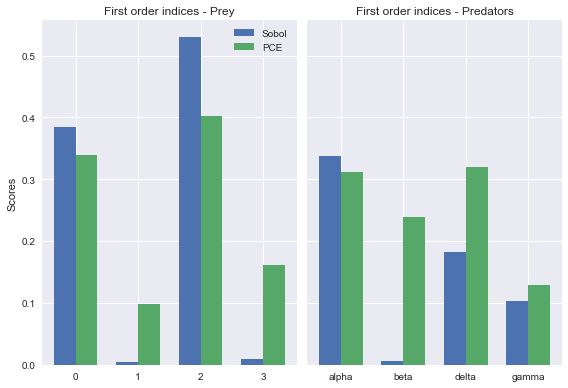

In [65]:
labels = ['alpha', 'beta', 'delta', 'gamma']

sobol_prey_s1 = prey_1684['S1']
sobol_pred_s1 = pred_1684['S1']
PCE_prey_s1 = Sobol_prey.values()
PCE_pred_s1 = Sobol_predators.values()

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, axs = plt.subplots(1,2, sharey=True)
rects1 = axs[0].bar(x - width/2, sobol_prey_s1, width, label='Sobol')
rects2 = axs[0].bar(x + width/2, PCE_prey_s1, width, label='PCE')

rects1 = axs[1].bar(x - width/2, sobol_pred_s1, width, label='Sobol')
rects2 = axs[1].bar(x + width/2, PCE_pred_s1, width, label='PCE')

# Add some text for labels, title and custom x-axis tick labels, etc.
axs[0].set_ylabel('Scores')
plt.xticks(x, labels)
axs[0].legend()
axs[0].set_title('First order indices - Prey')
axs[1].set_title('First order indices - Predators')

fig.tight_layout()

plt.show()

In [74]:
PCE_prey_st

{'alpha': 0.31190000737782175,
 'beta': 0.23874571913778755,
 'delta': 0.31983595933668857,
 'gamma': 0.12951831414770215}

In [75]:
##data
sobol_prey_st = prey_1684['ST']
sobol_pred_st = pred_1684['ST']
PCE_prey_st = pickle.load(open('data/PCE_st_prey_5.pkl','rb')).values()
PCE_pred_st = pickle.load(open('data/PCE_st_pred_5.pkl','rb')).values()



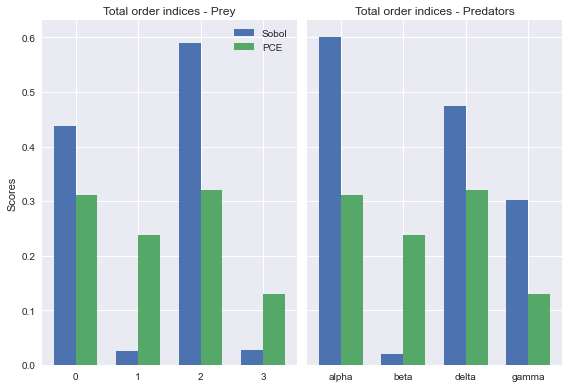

In [78]:
labels = ['alpha', 'beta', 'delta', 'gamma']

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, axs = plt.subplots(1,2, sharey=True)
rects1 = axs[0].bar(x - width/2, sobol_prey_st, width, label='Sobol')
rects2 = axs[0].bar(x + width/2, PCE_prey_st, width, label='PCE')

rects1 = axs[1].bar(x - width/2, sobol_pred_st, width, label='Sobol')
rects2 = axs[1].bar(x + width/2, PCE_pred_st, width, label='PCE')

# Add some text for labels, title and custom x-axis tick labels, etc.
axs[0].set_ylabel('Scores')
plt.xticks(x, labels)
axs[0].legend()
axs[0].set_title('Total order indices - Prey')
axs[1].set_title('Total order indices - Predators')

fig.tight_layout()

plt.show()